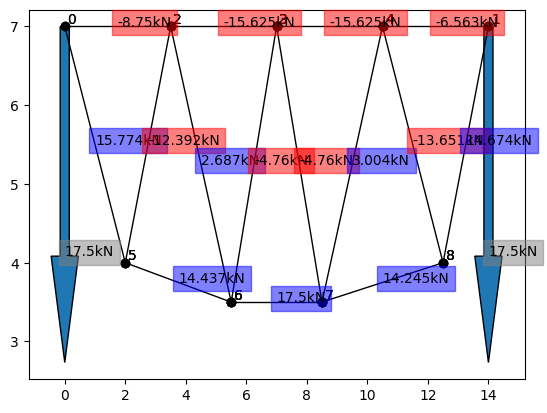

[0, 2, 3, 4, 1]
1644.1443393434226 [0, 2, 3, 4, 1]
0 0 2
1 2 3
2 3 4
3 4 1
4 0 5
5 5 2
6 2 6
7 6 3
8 3 7
9 7 4
10 4 8
11 8 1
12 8 7
13 7 6
14 6 5
[0, 1, 2, 3]


In [8]:
from truss_casadi import *
import numpy as np
import scipy as sp
from scipy.optimize import NonlinearConstraint, minimize, Bounds, shgo

truss, bridge_joints, xs = open_file("designs/truss_1.6_1.json", flip=False)
truss.plot(xs, plot_member=True, plot_external=False)
print(bridge_joints)
print(truss.real_cost(xs), bridge_joints)

bridge_links = []
for i, link in enumerate(truss.links):
    print(i, link.i0, link.i1)
    if (link.i0 in bridge_joints and link.i1 in bridge_joints) and i not in bridge_links:
        bridge_links.append(i)

print(bridge_links)

cost = Function('cost', [truss.xs], [truss.cost])

In [9]:
# def correct(X):   
#     X[bridge_joints[0]] = 0
#     X[bridge_joints[-1]] = 14
#     for j in bridge_joints:
#         X[j+len(truss.joints)] = 0
#         X[j+len(truss.joints)] = 0

#     return X

unknown_indices = list(np.arange(len(truss.joints)*2))
known_indices = []

for j in bridge_joints:
    # unknown_indices = np.delete(unknown_indices, j+len(truss.joints))
    unknown_indices.remove(j+len(truss.joints))
    known_indices.append(j+len(truss.joints))

# unknown_indices = np.delete(unknown_indices, bridge_joints[0])
unknown_indices.remove(bridge_joints[0])
unknown_indices.remove(bridge_joints[-1])
# unknown_indices = np.delete(unknown_indices, bridge_joints[-1])
known_indices.append(bridge_joints[0])
known_indices.append(bridge_joints[-1])

print(xs)
def correct(X):
    xs_ = xs.copy()
    for i in range(len(unknown_indices)):
        xs_[unknown_indices[i]] = X[i] 
    return xs_

unknowns = []
for i in unknown_indices:
    unknowns.append(xs[i])
print(unknowns)
print(unknown_indices, known_indices)
print(correct(unknowns))


[0.0, 14.0, 3.5, 7.0, 10.5, 2.0, 5.5, 8.5, 12.5, 7.0, 7.0, 7.0, 7.0, 7.0, 4.0, 3.5, 3.5, 4.0]
[3.5, 7.0, 10.5, 2.0, 5.5, 8.5, 12.5, 4.0, 3.5, 3.5, 4.0]
[2, 3, 4, 5, 6, 7, 8, 14, 15, 16, 17] [9, 11, 12, 13, 10, 0, 1]
[0.0, 14.0, 3.5, 7.0, 10.5, 2.0, 5.5, 8.5, 12.5, 7.0, 7.0, 7.0, 7.0, 7.0, 4.0, 3.5, 3.5, 4.0]


In [10]:
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint

nonlinear_constraints = []
for i, link in enumerate(truss.links):
    print(i, link.length)

print(len(truss.links))

for i in range(len(truss.links)):
    upper = np.inf
    if(i in bridge_links):
        upper = 3.5
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].length])(correct(x))), 1, upper))
    nonlinear_constraints.append(NonlinearConstraint(lambda x, i=i: float(Function('length{0}'.format(i),[truss.xs],[truss.links[i].force])(correct(x))), -6*3, 9*3))

lower = [-14] * len(unknowns) 
upper = [14] * len(unknowns)

bounds = tuple(zip(lower, upper))
print(bounds)

print(nonlinear_constraints)

res = minimize(lambda x: cost(correct(x)), unknowns, method='trust-constr',options={'initial_constr_penalty':1, 'maxiter':1000},  bounds=bounds, constraints=[*nonlinear_constraints])


0 sqrt((sq((xs_0-xs_2))+sq((xs_9-xs_11))))
1 sqrt((sq((xs_2-xs_3))+sq((xs_11-xs_12))))
2 sqrt((sq((xs_3-xs_4))+sq((xs_12-xs_13))))
3 sqrt((sq((xs_4-xs_1))+sq((xs_13-xs_10))))
4 sqrt((sq((xs_0-xs_5))+sq((xs_9-xs_14))))
5 sqrt((sq((xs_5-xs_2))+sq((xs_14-xs_11))))
6 sqrt((sq((xs_2-xs_6))+sq((xs_11-xs_15))))
7 sqrt((sq((xs_6-xs_3))+sq((xs_15-xs_12))))
8 sqrt((sq((xs_3-xs_7))+sq((xs_12-xs_16))))
9 sqrt((sq((xs_7-xs_4))+sq((xs_16-xs_13))))
10 sqrt((sq((xs_4-xs_8))+sq((xs_13-xs_17))))
11 sqrt((sq((xs_8-xs_1))+sq((xs_17-xs_10))))
12 sqrt((sq((xs_8-xs_7))+sq((xs_17-xs_16))))
13 sqrt((sq((xs_7-xs_6))+sq((xs_16-xs_15))))
14 sqrt((sq((xs_6-xs_5))+sq((xs_15-xs_14))))
15
((-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14), (-14, 14))
[<scipy.optimize._constraints.NonlinearConstraint object at 0x7fe886c0b8e0>, <scipy.optimize._constraints.NonlinearConstraint object at 0x7fe886c0b880>, <scipy.optimize._constraints.NonlinearConstraint object at 

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1782.8714198998657
                 x: [ 3.500e+00  7.000e+00  1.050e+01  3.500e+00  1.050e+01
                      4.448e+00  4.448e+00]
               nit: 47
              nfev: 320
              njev: 40
              nhev: 0
          cg_niter: 63
      cg_stop_cond: 4
              grad: [ 0.000e+00  2.180e-06  1.453e-06 -3.288e+01  3.288e+01
                     -7.419e+01 -7.419e+01]
   lagrangian_grad: [ 2.139e-14 -3.296e-15  1.192e-14 -3.337e-14 -8.987e-15
                     -2.117e-15  7.161e-15]
            constr: [array([ 3.500e+00]), array([-1.800e+01]), array([ 3.500e+00]), array([-1.800e+01]), array([ 3.500e+00]), array([-1.800e+01]), array([ 3.500e+00]), array([-1.800e+01]), array([ 4.332e+00]), array([ 2.228e+01]), array([ 2.552e+00]), array([-8.750e+00]), array([ 4.332e+00]), array([-7.426e+00]), array([ 4.332e+00]), array([-7.426e+00]

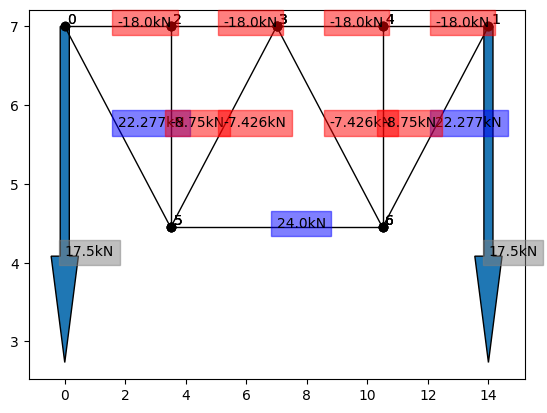

1782.8714198998664


In [ ]:
x = correct(res.x)
print(res)
for link in truss.links:
    print(float(Function('length',[truss.xs],[link.length])(x)))

print(x)
truss.plot(x, plot_member=True)

print(truss.real_cost(x))

In [ ]:
# opti = casadi.Opti()

# shape = len(xs)

# x = opti.variable(shape)

# def constraints():
#     for link in truss.links:
#         leng_fun = Function('leng_fun', [truss.xs], [link.length])
#         force_fun = Function('force_fun', [truss.xs], [link.force])   

#         # Constraint: length of each link cannot be less than 1
#         opti.subject_to(leng_fun(x) > 1)
#         # Constraint: force of each link must be within -27 and 18
#         opti.subject_to(opti.bounded(-9*3, force_fun(x), 6*3))

#     half_length = shape/2

#     # Constraint: First bridge joint must be at x=0
#     opti.subject_to(x[bridge_joints[0]] == 0)
#     # Constraint: Last bridge joint must be at x=14
#     opti.subject_to(x[bridge_joints[-1]] == 14)

#     for i in range(len(bridge_joints)-1):
#         i0 = bridge_joints[i]
#         i1 = bridge_joints[i+1]
#         print(i0, i1)
#         # Constraint: Each bridge joint must not be more than 3.5m apart
#         opti.subject_to(x[i1] - x[i0] < 3.5)
#         # Constraint: Bridge joints must be in order of ascending X value
#         opti.subject_to(x[i0] < x[i1])
#         # Constraint: Bridge joint y values = 0
#         opti.subject_to(x[i1+half_length] == 0)
#         if(i == 0):
#             opti.subject_to(x[i0+half_length] == 0)
    
#     # for i, joint in enumerate(truss.joints):
#     #     if(joint.type == JointType.PIN):
#     #         opti.subject_to(x[i] == 0)
#     #     if(joint.type == JointType.ROLLER):
#     #         opti.subject_to(x[i] == 14)

# constraints()

# cost = Function('cost', [truss.xs], [truss.cost])
# grad = Function('grad', [truss.xs], [casadi.gradient(truss.cost, truss.xs)])
# print(cost(xs), grad(xs))
# opti.minimize(cost(x))

# solver_options = {"ipopt.tol": 1e-8}

# opti.solver('ipopt', solver_options)


In [ ]:
# original_cost = cost(xs)
# opti.set_initial(x, xs)
# sol = opti.solve()
# sol_mat = np.asarray(sol.value(x))

In [ ]:
# truss.plot(sol_mat, plot_external=True, plot_member=True)
# truss.plot(sol_mat)
# print("Optimization Complete. Original Cost = {0}, Final Cost = {1}".format(truss.real_cost(xs), truss.real_cost(sol_mat)))
# print("Solution:",sol_mat)